# Multivariate Time Series Regression

So far, we have limited our modeling efforts to single time series. RNNs are naturally well suited to multivariate time series and represent a non-linear alternative to the Vector Autoregressive (VAR) models we covered in Chapter 8, Time Series Models. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, SGD
import keras.backend as K
from keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Data

For comparison, we illustrate the application of RNNs to modeling and forecasting several time series using the same dataset we used for the VAR example, monthly data on consumer close, and industrial production from the Federal Reserve's FRED service in Chapter 8, Time Series Models:

In [6]:
df_stocks = pd.read_csv('data/jpm_bars_2024-03-23.csv')
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)
df_stocks.index = pd.to_datetime(df_stocks.index)

In [7]:
df = df_stocks[['vwap', 'close']].iloc[11:,:]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2058 entries, 2016-01-20 to 2024-03-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vwap    2058 non-null   float64
 1   close   2058 non-null   float64
dtypes: float64(2)
memory usage: 48.2 KB


In [8]:
df.head()

,vwap,close
date,,
2016-01-20,55.378436,55.51
2016-01-21,55.652162,55.25
2016-01-22,56.787519,56.95
2016-01-25,56.137613,55.66
2016-01-26,56.810083,57.08


In [9]:
df.tail()

,vwap,close
date,,
2024-03-18,192.015808,192.66
2024-03-19,193.471047,193.79
2024-03-20,195.617114,196.33
2024-03-21,198.685277,199.06
2024-03-22,197.522578,196.62


In [10]:
df.shape

(2058, 2)

## Prepare Data

### Stationarity

We apply the same transformation—annual difference for both series, prior log-transform for industrial production—to achieve stationarity that we used in Chapter 8 on Time Series Models:

In [11]:
df_transformed = (pd.DataFrame({'vwap': np.log(df.vwap).diff(21),
                                'close': df.close.diff(21)})
                  .dropna())

### Scaling

Then we scale the transformed data to the [0,1] interval:

In [12]:
df_transformed = df_transformed.apply(minmax_scale)

### Plot original and transformed series

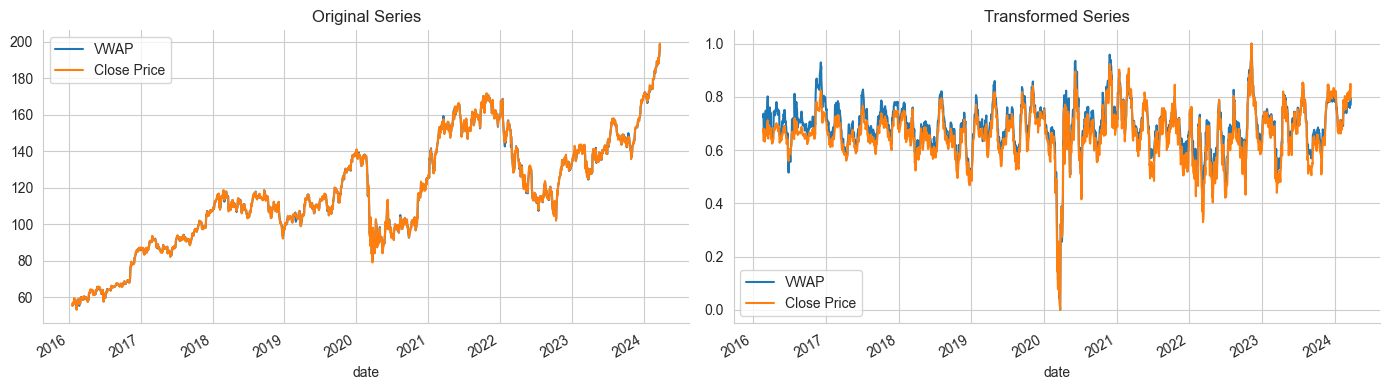

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
columns={'vwap': 'VWAP', 'close': 'Close Price'}
df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
df_transformed.rename(columns=columns).plot(ax=axes[1], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'multi_rnn', dpi=300)

### Reshape data into RNN format

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [14]:
type(df), df.shape

(pandas.core.frame.DataFrame, (2058, 2))

In [15]:
98*21

2058

In [16]:
df.values.reshape(-1, 21, 2).shape

(98, 21, 2)

However, we want rolling, not non-overlapping lagged values. The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [17]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [18]:
window_size = 22

In [19]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [20]:
df_transformed.head(1)

,vwap,close
date,,
2016-02-19,0.724109,0.669575


In [21]:
df_transformed.tail(1)

,vwap,close
date,,
2024-03-22,0.769737,0.796941


In [22]:
X.shape, y.shape

((2015, 22, 2), (2015, 2))

Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [23]:
test_size =520
train_size = X.shape[0]-test_size

In [24]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [25]:
y_test.index

DatetimeIndex(['2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-04', '2022-03-07', '2022-03-08', '2022-03-09',
               '2022-03-10', '2022-03-11',
               ...
               '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14',
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22'],
              dtype='datetime64[ns]', name='date', length=520, freq=None)

## Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 30 and 15 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [26]:
K.clear_session()

In [27]:
n_features = output_size = 2

In [28]:
lstm_units = 20
dense_units = 10

In [29]:
rnn = Sequential([layers.Input((window_size, n_features)),
                  layers.LSTM(lstm_units, return_sequences=False, recurrent_dropout=0.1),
                  layers.Dense(dense_units, activation='relu'),
                  layers.Dense(dense_units, activation='relu'),
                  layers.Dropout(0.1),
                  layers.Dense(output_size),
                  layers.Activation('linear')
                  ])

The model has 1,268 parameters, as shown here:

In [30]:
rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,182 (8.52 KB)

 Trainable params: 2,182 (8.52 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
rnn.compile(loss='mae', optimizer=SGD(learning_rate=0.01))

## Train the Model

We train for 50 epochs with a batch_size value of 20 using early stopping:

In [32]:
lstm_path = f'{results_path}\lstm.keras'

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)
print(os.getcwd())
print(results_path)

C:\Projects\CapstoneProject
results\multivariate_time_series


In [33]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [34]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5203
Epoch 1: val_loss improved from inf to 0.09608, saving model to results\multivariate_time_series\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5098 - val_loss: 0.0961
Epoch 2/100
59/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0860
Epoch 2: val_loss improved from 0.09608 to 0.08628, saving model to results\multivariate_time_series\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0872 - val_loss: 0.0863
Epoch 3/100
58/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0800
Epoch 3: val_loss improved from 0.08628 to 0.08286, saving model to results\multivariate_time_series\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0825 - val_loss: 0.0829
Epoch 4/100
56/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0700
Epoch 4: val_loss improved from 0.08286 to 0.07935, saving model to results\multivariate_time_series\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0732 - val_loss: 0.0794


## Evaluate the Results

Training stops early after 22 epochs, yielding a test MAE of 1.71, which compares favorably to the test MAE for the VAR model of 1.91.

However, the two results are not fully comparable because the RNN model produces 24 one-step-ahead forecasts, whereas the VAR model uses its own predictions as input for its out-of-sample forecast. You may want to tweak the VAR setup to obtain comparable forecasts and compare their performance:

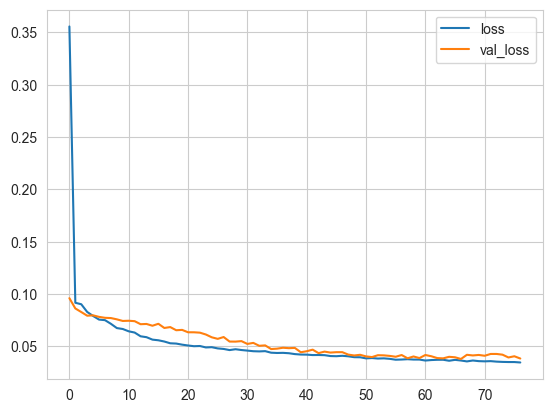

In [35]:
pd.DataFrame(result.history).plot();

In [36]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
y_pred.info()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 520 entries, 2022-02-28 to 2024-03-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vwap    520 non-null    float32
 1   close   520 non-null    float32
dtypes: float32(2)
memory usage: 8.1 KB


In [37]:
test_mae = mean_absolute_error(y_pred, y_test)

In [38]:
print(test_mae)

0.03801939375886182


In [39]:
y_test.index

DatetimeIndex(['2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-04', '2022-03-07', '2022-03-08', '2022-03-09',
               '2022-03-10', '2022-03-11',
               ...
               '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14',
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22'],
              dtype='datetime64[ns]', name='date', length=520, freq=None)

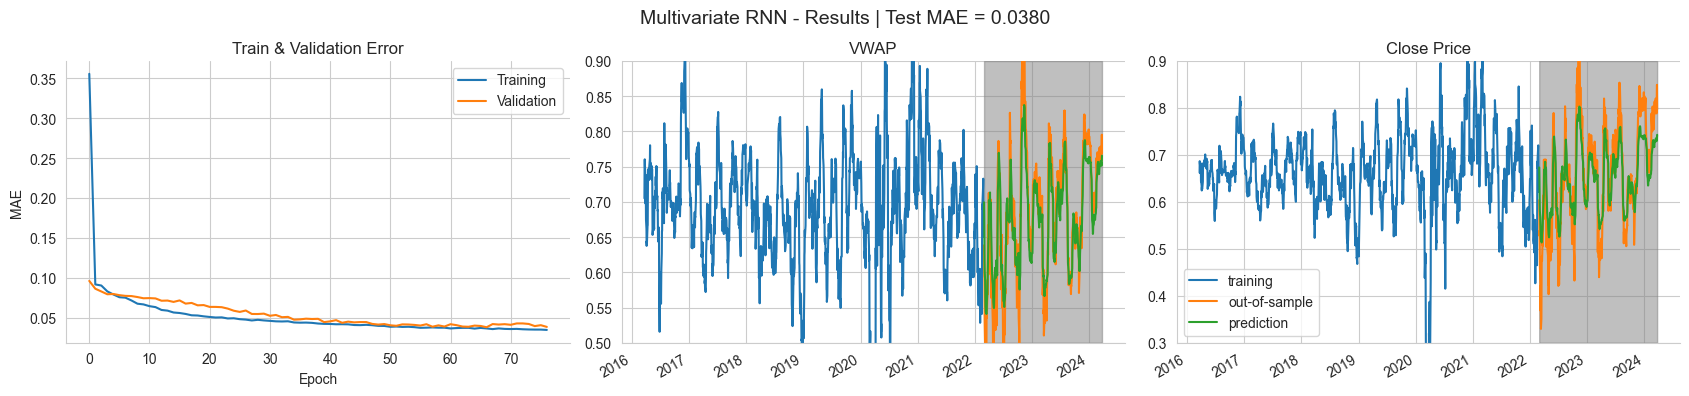

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 4))
pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
col_dict = {'vwap': 'VWAP', 'close': 'Close Price'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2016':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'multivariate_results', dpi=300);